In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from collections import namedtuple
from scipy.special import logsumexp

### Model

$$X_t = \phi X_{t-1} + W_t$$
$$Y_t = V_tX_t$$

$$V_t \sim N(1, 0.1^2)$$
$$W_t \sim N(0, 1)$$

In [3]:
def simulate(T, phi, seed=0):
    np.random.seed(seed)
    x = np.zeros(T)    
    x[0] = np.random.normal()
    
    for t in range(1, T):
        x[t] = np.random.normal(loc=phi*x[t-1])
    y = x * np.random.normal(loc=1,scale=0.01,size=T)

    return x, y

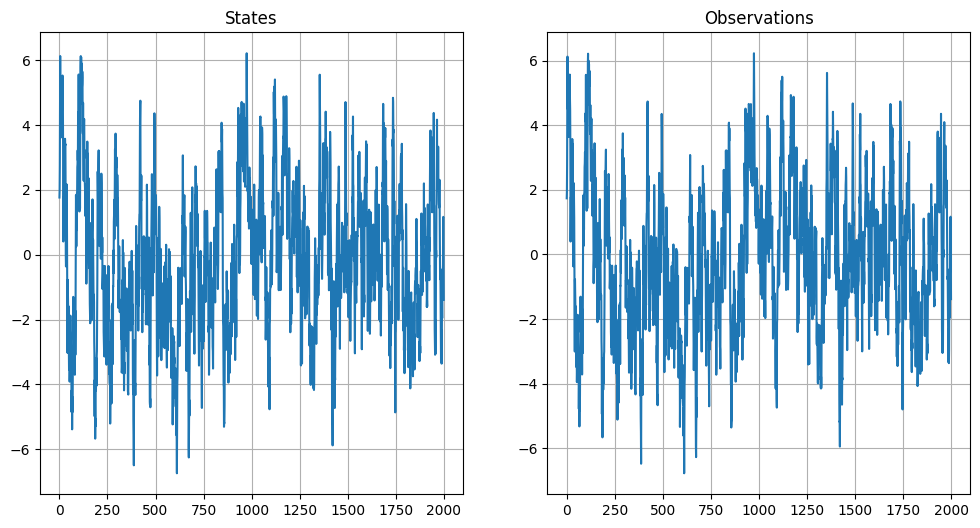

In [4]:
T= 2000 # time steps
phi = 0.9 
states, observations = simulate(T, phi)
fig, ax = plt.subplots(figsize=(12, 6),ncols=2, nrows=1)
ax[0].plot(states)
ax[0].set_title('States')
ax[0].grid()
ax[1].plot(observations)
ax[1].set_title('Observations')
ax[1].grid()

Below is the code implementing the parameter estimation scheme

In [7]:
def q(y, x):
    return st.norm.pdf(
        y,
        loc=x, 
        scale=0.1
    )

def log_q(y, x):
    return st.norm.logpdf(
        y,
        loc=x, 
        scale=0.1
    )
    
def p(x_2, x_1, phi):
    return st.norm.pdf(
        x_2,
        loc=phi*x_1,
    )
    

def resample_propogate_log(N, observation, particles, phi):
    logw = log_q(observation, particles)
    logw -= logsumexp(logw)
    normalised_weights = np.exp(logw)
    resamples = np.random.choice(
        a=particles,
        size=N,
        p=normalised_weights
    )
    particles = np.random.normal(
        loc=phi*resamples,
    )
    return particles

def d_phi(phi, x_2, x_1): # dphi/dp = d(logphi)/dphi * phi
    return p(x_2, x_1, phi)*(
        (x_2 - phi*x_1) * x_1
    )

def a(n): # step size
    return 1/(n+1)

def estimate_params(T, observations, N=1000):
    #initial config
    phi = 0.1
    particles = np.random.normal(loc=0,size=N)
    weights = 1/N * np.ones(N)
    #weights = np.zeros(N)
    
    param_evolution = [phi]
    for j in range(T-1):
        observation = observations[j]
        next_particles = resample_propogate_log(
            N, observation, particles, phi
        )
        next_observation = observations[j+1]
        new_weights = np.empty(N)
        for i in range(N):
            normaliser = np.sum(
                (
                    p(next_particles[i], particles, phi)*
                    q(observation, particles)
                )
            )
            if normaliser == 0: # normaliser == 0 iff all probabilities are zero 
                continue
            new_weights[i] = (
                np.sum( 
                    d_phi(phi, next_particles[i], particles)*
                    q(observation, particles)
                )+np.sum(
                    p(next_particles[i], particles, phi)*
                    q(observation, particles)*
                    weights
                )
            )/normaliser
            
        new_weights = new_weights - np.mean(new_weights)
        normaliser = np.sum(
            q(next_observation, next_particles)
        )
        if(normaliser != 0): # normaliser == 0 iff all probabilities are zero, but lets move this to log space hopefully
            phi += a(j)*np.sum(
                q(next_observation, next_particles)*new_weights
            )/normaliser
            phi = min(max(phi,0.001),2)
        
        weights=new_weights
        param_evolution.append(phi)
        
        print(f'Iteration {j+1}/{T-1} phi:{phi})')
        
        particles = next_particles
    return param_evolution    

In [11]:
def plot_param_estimation(guesses):
    guesses = np.array(guesses)

    phis = guesses

    fig, ax = plt.subplots()
    ax.plot(phis, label="phi", color="green")
    ax.hlines(y=phi, xmin=0, xmax=len(phis),label="true phi", linestyle="dashed", color="red")
    fig.legend()
    ax.grid()
    fig.set_figheight(6)
    fig.set_figwidth(10)

In [ ]:
guesses = estimate_params(T=500, observations=observations, N=1000)

Iteration 1/499, phi = 2.0
Iteration 2/499, phi = 0.9579721969820991
Iteration 3/499, phi = 2.0
Iteration 4/499, phi = 0.001
Iteration 5/499, phi = 2.0
Iteration 6/499, phi = 1.6638771062811544
Iteration 7/499, phi = 0.001
Iteration 8/499, phi = 2.0
Iteration 9/499, phi = 1.2677782512491067
Iteration 10/499, phi = 0.7306697247328586
Iteration 11/499, phi = 1.3772074613637797
Iteration 12/499, phi = 0.8727370940706192
Iteration 13/499, phi = 0.9758208605758767
Iteration 14/499, phi = 1.001833463413361
Iteration 15/499, phi = 0.9387626864725179
Iteration 16/499, phi = 1.3371123018288562
Iteration 17/499, phi = 0.4976625831023418
Iteration 18/499, phi = 1.0467294919481551
Iteration 19/499, phi = 0.75489535147062
Iteration 20/499, phi = 0.4098565546588341
Iteration 21/499, phi = 0.4278020184612088
Iteration 22/499, phi = 0.4907747957103136
Iteration 23/499, phi = 0.4905507924044058
Iteration 24/499, phi = 0.5877860187065217
Iteration 25/499, phi = 0.5283782046502103
Iteration 26/499, phi =

NameError: name 'plot_param_estimation' is not defined

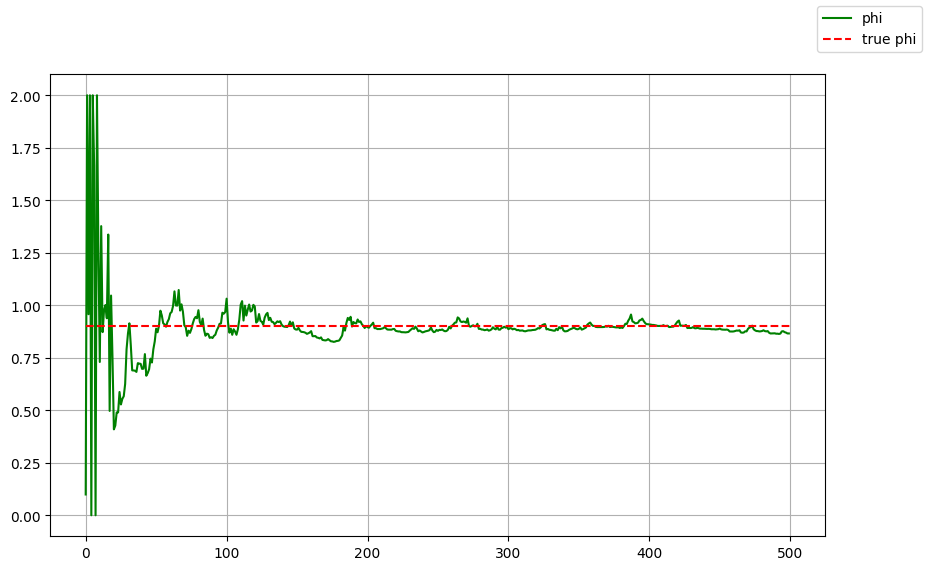

In [12]:
plot_param_estimation(guesses)

Below is the vectorised code

In [8]:
def estimate_params(T, observations, N=1000, seed=0):
    np.random.seed(seed)
    phi = 0.1
    particles = np.random.normal(0, 1, size=N)
    weights = np.zeros(N)

    param_evolution = [phi]

    for j in range(T - 1):
        y_t = observations[j]
        y_next = observations[j + 1]

        # Resample & propagate
        next_particles = resample_propogate_log(
            N, y_t, particles, phi
        )

        # ---------- VECTORISED WEIGHT UPDATE ----------

        # Shape: (N, N)
        P = p(next_particles[:, None], particles[None, :], phi)
        Q = q(y_t, particles)

        normalisers = P @ Q                     # (N,)
        valid = normalisers > 0

        dP = d_phi(phi, next_particles[:, None], particles[None, :])

        new_weights = np.zeros(N)
        new_weights[valid] = (
            (dP @ Q)[valid] +
            (P @ (Q * weights))[valid]
        ) / normalisers[valid]

        # Center weights
        new_weights -= np.mean(new_weights)

        # ---------- PHI UPDATE ----------
        q_next = q(y_next, next_particles)
        norm_phi = np.sum(q_next)

        if norm_phi > 0:
            phi += a(j) * np.sum(q_next * new_weights) / norm_phi

        # Project phi
        phi = np.clip(phi, 0.001, 2)

        weights = new_weights
        particles = next_particles
        param_evolution.append(phi)

        print(f"Iteration {j+1}/{T-1}, phi = {phi}")

    return param_evolution

In [47]:
bunch_of_guesses = [
    estimate_params(T=1500, observations=observations, N=(i+1)*500, seed=0)
    for i in range(5)
]

Iteration 1/1499, phi = 2.0
Iteration 2/1499, phi = 1.089920361489264
Iteration 3/1499, phi = 2.0
Iteration 4/1499, phi = 0.001
Iteration 5/1499, phi = 2.0
Iteration 6/1499, phi = 1.5195801335543357
Iteration 7/1499, phi = 0.001
Iteration 8/1499, phi = 1.9216227749085997
Iteration 9/1499, phi = 1.0732186382069253
Iteration 10/1499, phi = 0.8697151482631742
Iteration 11/1499, phi = 1.3489931969707538
Iteration 12/1499, phi = 0.8643652483132891
Iteration 13/1499, phi = 0.9735786602604725
Iteration 14/1499, phi = 0.9907763660790078
Iteration 15/1499, phi = 0.9649286650065263
Iteration 16/1499, phi = 1.3081216638603201
Iteration 17/1499, phi = 0.5156438021711826
Iteration 18/1499, phi = 1.0098548353740187
Iteration 19/1499, phi = 0.7552383884790875
Iteration 20/1499, phi = 0.41231664585276534
Iteration 21/1499, phi = 0.42913758950295366
Iteration 22/1499, phi = 0.489647752724665
Iteration 23/1499, phi = 0.4858945875098956
Iteration 24/1499, phi = 0.57815582399305
Iteration 25/1499, phi = 0

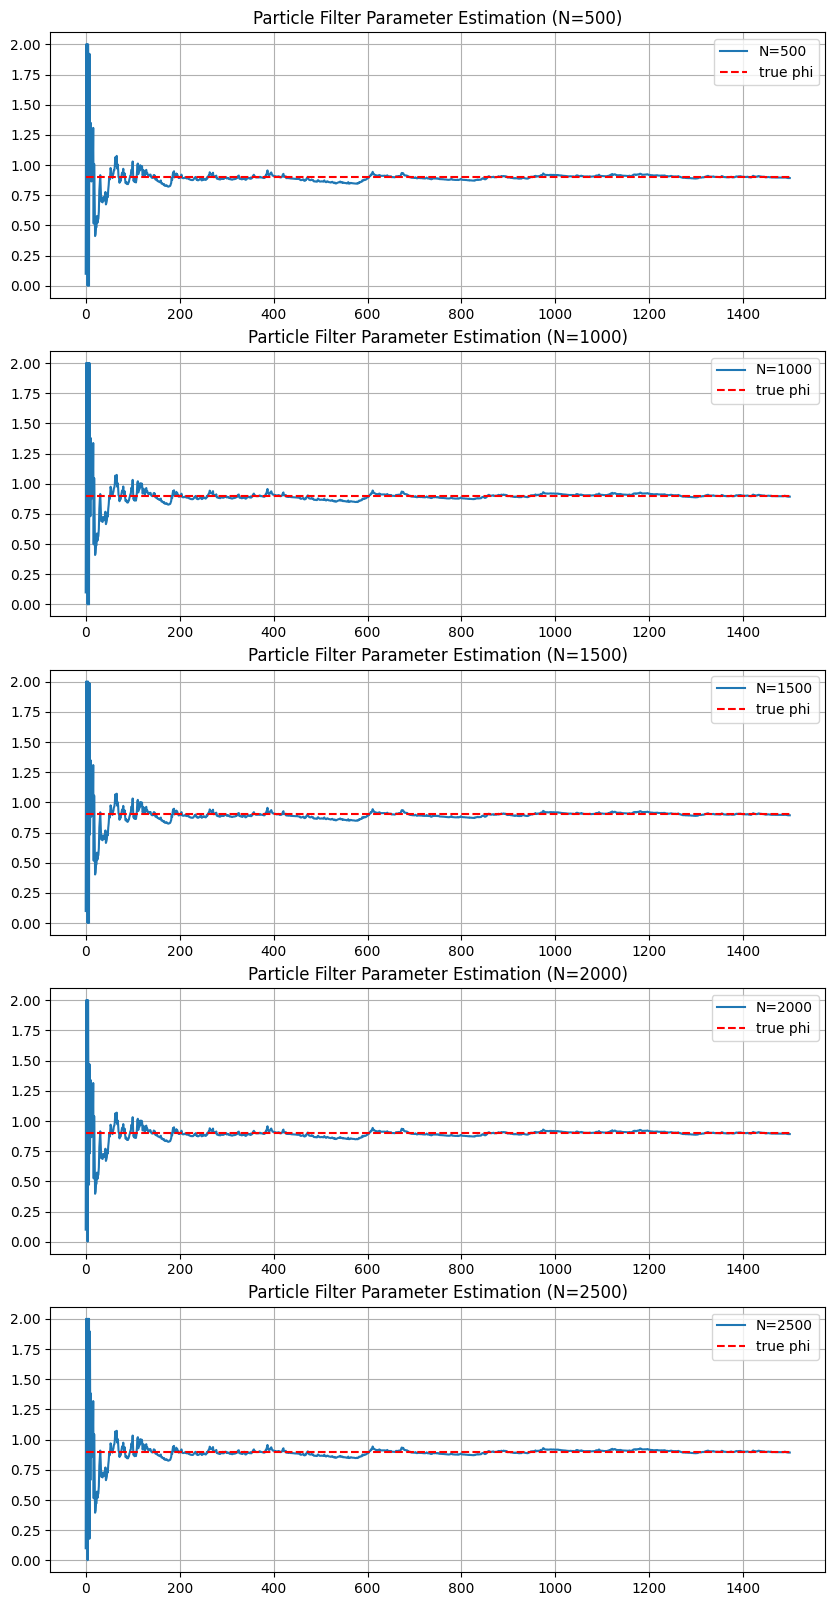

In [49]:
fig, ax = plt.subplots(nrows=5, figsize=(10, 20))
for i, guesses in enumerate(bunch_of_guesses):
    ax[i].plot(guesses, label=f"N={(i+1)*500}")
    ax[i].hlines(y=phi, xmin=0, xmax=len(guesses), label="true phi", linestyle="dashed", color="red")
    ax[i].legend()
    ax[i].grid()
    ax[i].set_title(f"Particle Filter Parameter Estimation (N={(i+1)*500})")